# N random initialisations for disag model fitting
Fitting of sigmoid models requires initialisation. Besides estimated model parameters the models can be initialised with random parameters. Here it is analysed how log likelyhood over genes changes depending on N random initialisation.

In [ ]:
library('dplyr')
library(plyr)
library(ggplot2)

library(Biobase)
library(BiocParallel)
library(circlize)
import::from(compiler, cmpfun)
library(ComplexHeatmap)
import::from(cowplot, plot_grid)
library(DESeq2)
library(ggplot2)
import::from(grDevices, dev.off, graphics.off, pdf)
library(knitr)
library(Matrix)
library(methods)
import::from(stats, dnbinom, median, optim, p.adjust, pchisq, rnbinom, rnorm, runif, sd, time)
library(SummarizedExperiment)
import::from(utils, packageDescription)
import::from(zoo,as.zoo,rollapply)

sapply(list.files('/home/khrovatin/git/ImpulseDE2_extended/R', full.name=TRUE), source)

In [ ]:
server=TRUE
if (server){
    pathCounts='/home/khrovatin/timeTrajectoriesNet/data/counts/'
    pathConditions='/home/khrovatin/timeTrajectoriesNet/data/RPKUM/'
}else{
    pathCounts='/home/karin/Documents/timeTrajectories/data/countsRaw/combined/'
    pathConditions='/home/karin/Documents/timeTrajectories/data/RPKUM/combined/'
}

In [8]:
# Load and prepare data for impulse
genes<-read.table(paste(pathCounts,'mergedGenes_counts.tsv',sep=''), header=TRUE,row.names=1, sep="\t")
conditions<-read.table(paste(pathConditions,'conditions_mergedGenes.tsv',sep=''), header=TRUE,row.names='Measurment', sep="\t")
conditions[conditions=='']=NA
#R imported colnames of genes with changes but gene IDs remained ok
rownames(conditions)<-make.names(rownames(conditions))

#PHENOTYPES_ORDERED=c('no_agg', 'stream', 'lag', 'tag', 'tip', 'slug', 'mhat', 'cul', 'FB', 'yem')
PHENOTYPES_ORDERED=c('no_agg', 'stream', 'lag', 'tag', 'tip', 'slug', 'mhat', 'cul', 'FB')
PHENOTYPES_X=data.frame(Phenotype=PHENOTYPES_ORDERED,X=c(1:length(PHENOTYPES_ORDERED)))

Y=conditions[conditions$Group=='WT', 'Time',drop=F]
Y[,'Sample']=rownames(Y)
Y[,'Condition']='case'
Y<-Y[order(Y$Time),]
X=genes[sample.int(n=nrow(genes),size=100),Y$Sample]

In [ ]:
# Run impulse and save information about runtime, sum of LL over genes, and use of random/estimnated param
#TODO here measuret time does not match time reported by the impulse
nRandomInits<-c(0,5,10,20,30,40,50,70,100)
vecRandomInits<-c()
vecLL<-c()
vecNRandom<-c()
vecNEstimated<-c()
vecModels<-c()
vecUsedTimes<-c()
for(nRandomInit in nRandomInits){
    NRANDOMINITIMPULSEDE2EXTENDED=nRandomInit
    start_time <- Sys.time()
    objectImpulseDE2 <- runImpulseDE2(matCountData = as.matrix(X), dfAnnotation = Y,boolCaseCtrl = FALSE,
                                  vecConfounders = NULL,
                                  boolIdentifyTransients = TRUE,scaNProc = 40,boolExtended=TRUE)
    used_time<-Sys.time()-start_time
    vecUsedTimes<-c(vecUsedTimes,used_time)

    for(model in c('Const','Sigmoid','Impulse','ThreeSigmoid','FourSigmoid')){
        nRandom=0
        nEstimated=0
        sumLL=0
        for(gene in names(objectImpulseDE2@lsModelFits$case)){
            paramEstimation<-objectImpulseDE2@lsModelFits$case[[gene]][[paste('ls',model,'Fit',sep='')
                                                                   ]]$paramEstimation
            ll<-objectImpulseDE2@lsModelFits$case[[gene]][[paste('ls',model,'Fit',sep='')
                                                                   ]]$scaLL
            if(paramEstimation=='random'){
                nRandom=nRandom+1
            }else if(paramEstimation =='estimated'){
                nEstimated=nEstimated+1
            }
         sumLL=sumLL+ll
        }
        vecRandomInits<-c(vecRandomInits,nRandomInit)
        vecLL<-c(vecLL,sumLL)
        vecNRandom<-c(vecNRandom,nRandom)
        vecNEstimated<-c(vecNEstimated,nEstimated)
        vecModels<-c(vecModels,model)
    }
}
data<-data.frame(nRandomInit=vecRandomInits,model=vecModels,LL=vecLL,nRandom=vecNRandom,
                 nEstimated=vecNEstimated)
dataTime<-data.frame(nRandomInit=nRandomInits,time<-vecUsedTimes)

How log likelyhood of fits changes if random parameter initialisations are added.

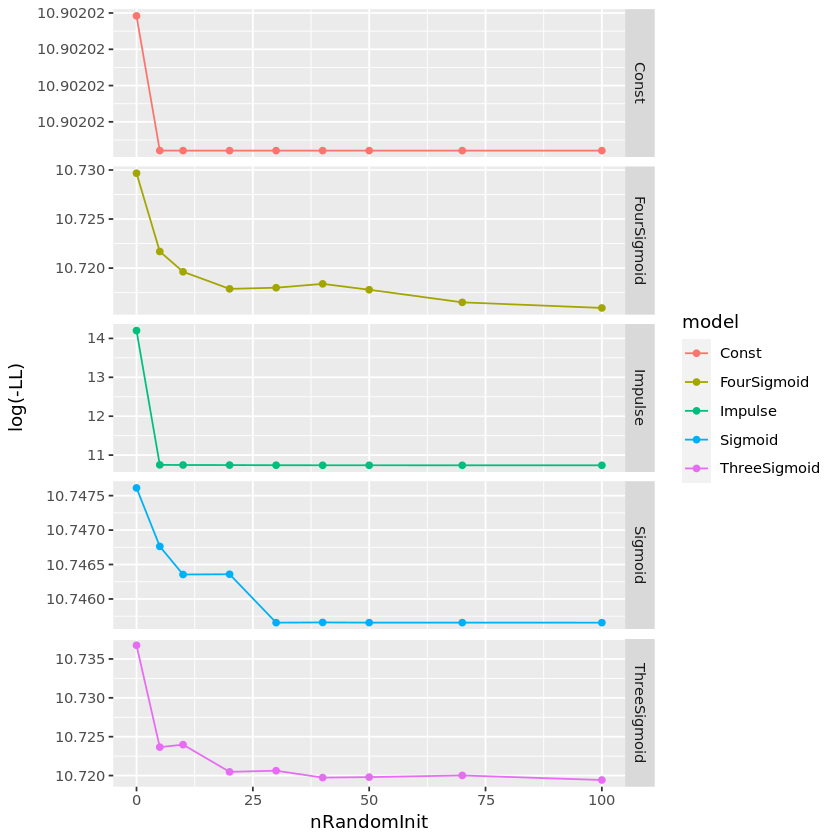

In [75]:
ggplot(data, aes(x=nRandomInit, y=log(-LL), group=model)) +
  geom_line(aes(color=model))+
  geom_point(aes(color=model))+
 facet_grid(model ~ .,scales='free')

Which parameter initialisation (random or estimated) is used depending on N of random initialisations. Given as ratio of randomly initialised vs all fits.

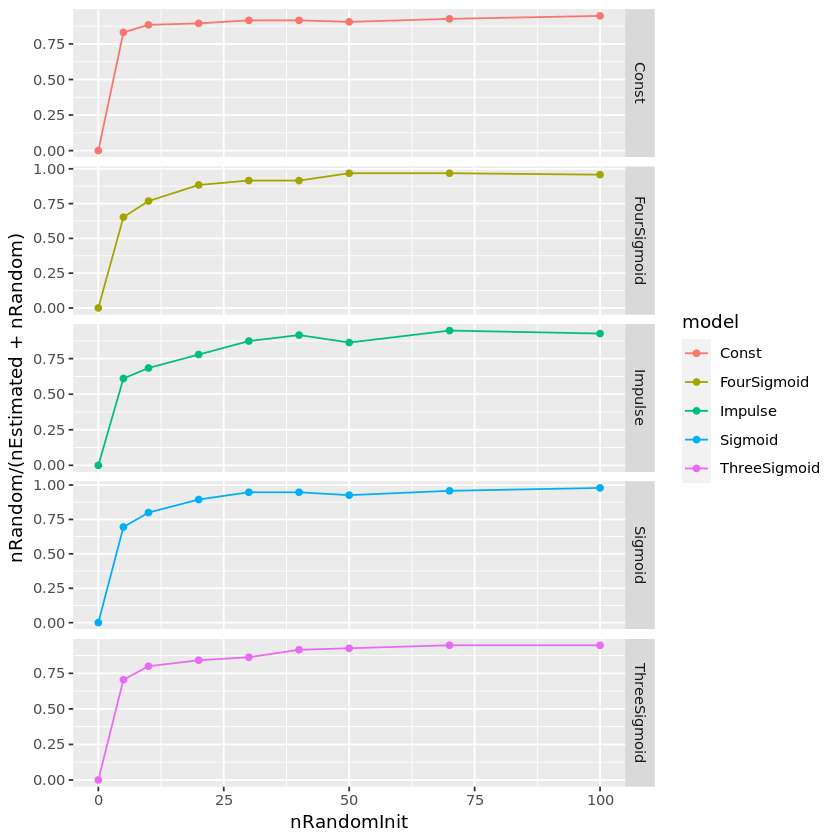

In [76]:
ggplot(data, aes(x=nRandomInit, y=nRandom/(nEstimated+nRandom), group=model)) +
  geom_line(aes(color=model))+
  geom_point(aes(color=model))+
 facet_grid(model ~ .,scales='free')

TODO How long does it take to run ImpulseDE2.extended based on N random init.

In [ ]:
#TODO this does not match the time reported by impulse
ggplot(dataTime, aes(x=nRandomInit, y=time) )+ geom_line() + geom_point()